In [58]:
using OptimalTransport, Distances, Distributions, LinearAlgebra
using Plots, VegaLite
using DataFrames

In [59]:
n = 10
μ = rand(n,2)
ν = rand(n,2).+0.5;

N = size(μ)[1]
M = size(ν)[1]
μ_n = rand(N)
μ_n = μ_n/sum(μ_n)
ν_m = rand(M);
ν_m = ν_m/sum(ν_m);
C = pairwise(SqEuclidean(), μ, ν, dims=1);

In [60]:
"""
    CreateEdges(μ,ν,γ)
Creates the edges for plotting.
μ and ν correspond to the positions of the mass
of the distributions.
"""
function CreateEdges(μ,ν,γ)
    edges = Array{Float64}(undef, 0, 2)
    pe    = []
    for i in 1:size(μ)[1], j in 1:size(ν)[1]
        edges  = vcat(edges,[μ[i,1],μ[i,2]]')
        edges  = vcat(edges,[ν[j,1],ν[j,2]]')
        pe     = vcat(pe,string([i,j]))
        pe     = vcat(pe,string([i,j]))
    end
    df = DataFrame(edges_x=edges[:,1],edges_y = edges[:,2],pe=pe);
    edge_w = []
    for i in 1:size(γ)[1], j in 1:size(γ)[1]
        edge_w = vcat(edge_w,γ[i,j])
        edge_w = vcat(edge_w,γ[i,j])
    end
    df[!,"ew"] = edge_w./maximum(edge_w);
    return df
end

"""
    PlotOT(μ,ν,γ;title="",width=200,height=200)
VegaLite.jl specification for creating visulizations
of Optimal Transport plan.
"""
function PlotOT(μ,ν,γ;title="",width=300,height=300)
    df = CreateEdges(μ,ν,γ)
    v1 = @vlplot(
        mark={:circle,opacity=1},
        x={μ[:,1],type="quantitative",axis=nothing},
        y={μ[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height,
        size={μ_n,legend=nothing,type="q"})
    v2 = @vlplot(
        mark={"type"=:circle,color="red",opacity=1},
        x={ν[:,1],type="quantitative",axis=nothing},
        y={ν[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height,
        size={ν_m,legend=nothing,type="q"})

    v3 = @vlplot(
        mark={"type"=:line,color="black",clip=false},
        data = df,
        encoding={
        x={"edges_x:q",axis=nothing},
        y={"edges_y:q",axis=nothing},
        opacity={"ew:q",legend=nothing},
        size={"ew:o",scale={range=[0,2]},legend=nothing},
        detail={"pe:o"}},
        width=width,
        height=height
    )
    v = @vlplot(view={stroke=nothing},title={text=title, dy=-25, fontSize=14})+v3+v2+v1
    return v
end;

## Entropically regularised optimal transport

We may add an entropy term to the Monge-Kantorovich problem to obtain the
**entropically regularised** optimal transport problem
$$
\inf_{\gamma \in \Pi(\mu, \nu)} \langle \gamma, C \rangle + \epsilon \Omega(\gamma),
$$
where $\Omega(\gamma) = \sum_{i, j} \gamma_{ij} \log(\gamma_{ij})$ is the negative
entropy of the coupling $\gamma$ and $\epsilon$ controls the strength of the regularisation.

This problem is *strictly convex* and admits a very efficient iterative scaling scheme for
its solution known as the [Sinkhorn algorithm](https://doi.org/10.1214/aoms/1177703591).

We compute the optimal entropically regularised transport plan:

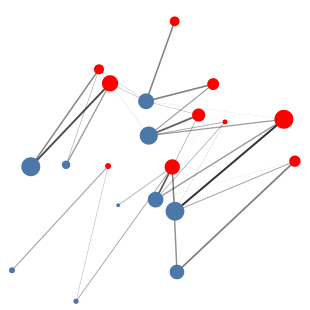

In [65]:
function Sinkhorn(μ,ν,C,ϵ=1;n_iter = 100)
    K = @. exp(-C/ϵ)
    v = ones(size(μ)[1])
    local u
    for i = 1:n_iter
        u = exp.(log.(μ) - log.(K*v))
        v = exp.(log.(ν) .- log.(K'*u))
    end
    return diagm(u) * K * diagm(v)
end

γ = round.(Sinkhorn(μ_n,ν_m,C,0.01,n_iter=1000), digits=4)

otplot = PlotOT(μ,ν,γ)

### Sinkhorn barycenters

For a collection of discrete probability measures $\{\mu_i\}_{i=1}^N \subset \mathcal{P}$,
cost matrices $\{C_i\}_{i=1}^N$, and positive weights $\{\lambda_i\}_{i=1}^N$ summing to $1$,
the entropically regularised **barycenter** in $\mathcal{P}$ is the discrete probability
measure $\mu$ that solves
$$
\inf_{\mu \in \mathcal{P}} \sum_{i = 1}^N \lambda_i \operatorname{OT}_{\epsilon}(\mu, \mu_i)
$$
where $\operatorname{OT}_\epsilon(\mu, \mu_i)$ denotes the entropically regularised
optimal transport cost with marginals $\mu$ and $\mu_i$, cost matrix $C$, and entropic
regularisation parameter $\epsilon$.

We set up two measures and compute the weighted barycenters. We choose weights
$\lambda_1 \in \{0.25, 0.5, 0.75\}$.

In [62]:
function sinkhorn_barycenter(μ, C, ε, w; tol=1e-9, check_marginal_step=10, max_iter=1000)
    sums = sum(μ; dims=1)
    if !isapprox(extrema(sums)...)
        throw(ArgumentError("Error: marginals are unbalanced"))
    end
    K = exp.(-C / ε)
    converged = false
    v = ones(size(μ))
    u = ones(size(μ))
    N = size(μ, 2)
    for n in 1:max_iter
        v = μ ./ (K' * u)
        a = ones(size(u, 1))
        a = prod((K * v)' .^ w; dims=1)'
        u = a ./ (K * v)
        if n % check_marginal_step == 0
            # check marginal errors
            err = maximum(abs.(μ .- v .* (K' * u)))
            @debug "Sinkhorn algorithm: iteration $n" err
            if err < tol
                converged = true
                break
            end
        end
    end
    if !converged
        @warn "Sinkhorn did not converge"
    end
    return u[:, 1] .* (K * v[:, 1])
end

sinkhorn_barycenter (generic function with 1 method)

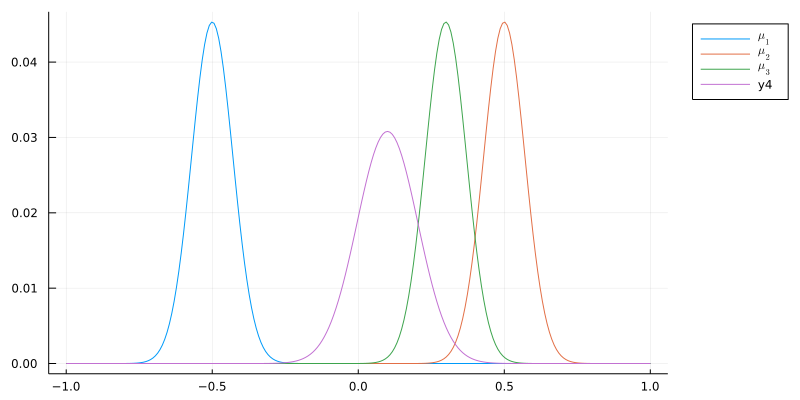

In [84]:
support = range(-1, 1; length=250)
mu1 = exp.(-(support .+ 0.5) .^ 2 ./ 0.1^2)
mu1 ./= sum(mu1)
mu2 = exp.(-(support .- 0.5) .^ 2 ./ 0.1^2)
mu2 ./= sum(mu2)
mu3 = exp.(-(support .- 0.3) .^ 2 ./ 0.1^2)
mu3 ./= sum(mu3)

plt = plot(; size=(800, 400), legend=:outertopright)
plot!(plt, support, mu1; label=raw"$\mu_1$")
plot!(plt, support, mu2; label=raw"$\mu_2$")
plot!(plt, support, mu3; label=raw"$\mu_3$")

mu = hcat(mu1, mu2)
mu = hcat(mu1, mu2, mu3)
C  = pairwise(SqEuclidean(), support'; dims=2)
γ  = sinkhorn_barycenter(mu, C, 0.01, [0.3,0.3,0.3])
plot!(plt, support, γ)
# for λ1 in (0.25, 0.5, 0.75)
#     λ2 = 1 - λ1
#     a = sinkhorn_barycenter(mu, C, 0.01, [λ1, λ2]; max_iter=1000)
#     plot!(plt, support, a; label="\$\\mu \\quad (\\lambda_1 = $λ1)\$")
# end
# plt